# Modeling and Simulation in Python

Chapter 7: Thermal systems

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [2]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib notebook

from modsim import *

### The coffee cooling problem.

I'll use a `State` object to store the initial temperature.


In [3]:
init = State(temp=90)
init

,value
temp,90


And a `System` object to contain the system parameters.

In [4]:
coffee = System(init=init,
                volume=300,
                r=0.01,
                T_env=22,
                t0=0, 
                t_end=30,
                dt=1)
coffee

,value
init,temp 90 dtype: int64
volume,300
r,0.01
T_env,22
t0,0
t_end,30
dt,1


The `update` function implements Newton's law of cooling.

In [5]:
def update(state, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    system: System object
    
    returns: State (temp)
    """
    unpack(system)
    T = state.temp
    T += -r * (T - T_env) * dt

    return State(temp=T)

Here's how it works.

In [6]:
update(init, coffee)

,value
temp,89.32


Now we can run simulations using the same function from the previous chapter.

In [7]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    ts = linrange(t0, t_end-dt, dt)
    
    for t in ts:
        frame.loc[t+dt] = update_func(frame.loc[t], system)
    
    system.results = frame

And here's how it works.

In [8]:
run_simulation(coffee, update)
coffee.results

,temp
0,90.000000
1,89.320000
2,88.646800
3,87.980332
4,87.320529
5,86.667323
6,86.020650
7,85.380444
8,84.746639
9,84.119173


Here's what the results look like.

<IPython.core.display.Javascript object>


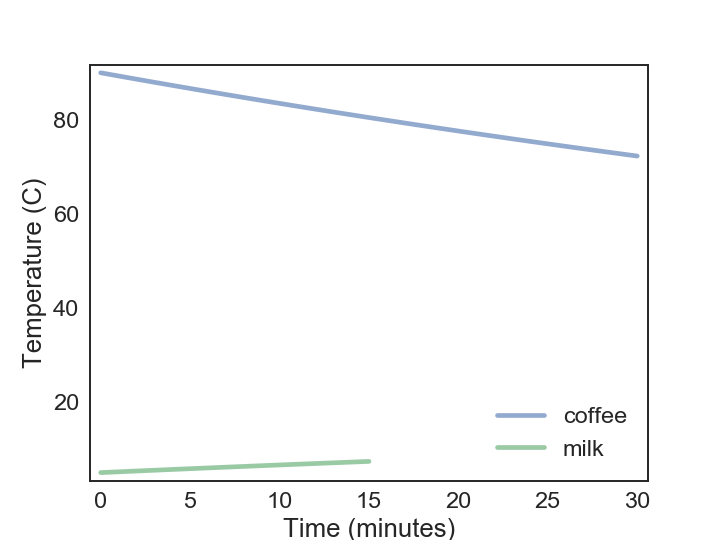

In [9]:
plot(coffee.results.temp, label='coffee')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

After running the simulation, we can extract the final temperature from the results.

In [10]:
def final_temp(system):
    """Final temperature.
    
    If system has no results, return initial temp.
    
    system: System object.
    
    returns: temperature (degC)
    """    
    if hasattr(system, 'results'):
        return system.results.temp[system.t_end]
    else:
        return system.init.temp

It will be convenient to wrap these steps in a function.  `kwargs` is a collection of whatever keyword arguments are provided; they are passed along as arguments to `System`.

In [11]:
def make_system(T_init=90, r=0.01, volume=300, t_end=30):
    """Runs a simulation with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(temp=T_init)
    
    system = System(init=init,
                    volume=volume,
                    r=r,
                    T_env=22, 
                    t0=0,
                    t_end=t_end,
                    dt=1)
    return system

Here's how we use it:

In [12]:
coffee = make_system()
run_simulation(coffee, update)
final_temp(coffee)

72.299625390403094

**Exercise:**  Simulate the temperature of 50 mL of milk with a starting temperature of 5 degC, in a vessel with the same insulation, for 15 minutes, and plot the results.

In [17]:
milk = make_system(T_init=5, r=0.01, volume=50, t_end=15)
run_simulation(milk, update)

<IPython.core.display.Javascript object>


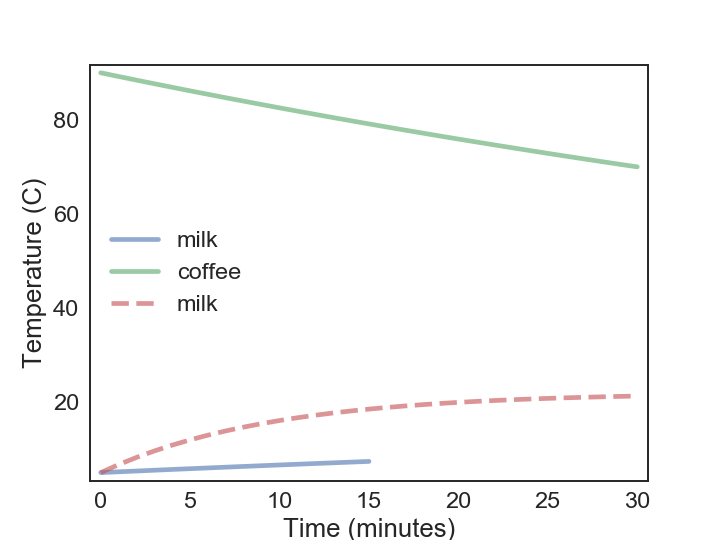

In [19]:
newfig()
plot(milk.results.temp, label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

### Using `fsolve`

As a simple example, let's find the roots of this function; that is, the values of `x` that make the result 0.

In [20]:
def func(x):
    return (x-1) * (x-2) * (x-3)

`modsim.py` provides `fsolve`, which does some error-checking and then runs `scipy.optimize.fsolve`.  The first argument is the function whose roots we want.  The second argument is an initial guess.

In [21]:
fsolve(func, x0=0)

array([ 1.])

Usually the root we get is the one that's closest to the initial guess.

In [22]:
fsolve(func, 1.9)

array([ 2.])

In [23]:
fsolve(func, 2.9)

array([ 3.])

But not always.

In [24]:
fsolve(func, 1.5)

array([ 3.])

We want to find the value of `r` that makes the final temperature 70, so we define an "error function" that takes `r` as a parameter and returns the difference between the final temperature and the goal.

In [25]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(r=r)
    run_simulation(system, update)
    return final_temp(system) - 70

With `r=0.01`, we end up a little too warm.

In [26]:
error_func1(r=0.01)

2.2996253904030937

The return value from `fsolve` is an array with a single element, the estimated value of `r`.

In [27]:
solution = fsolve(error_func1, 0.01, xtol=1e-8)
r_coffee = solution[0]
r_coffee

0.011543084583978345

If we run the simulation with the estimated value of `r`, the final temperature is 70 C, as expected.

In [28]:
coffee = make_system(r=r_coffee)
run_simulation(coffee, update)
final_temp(coffee)

70.0

**Exercise:**  When you call `fsolve`, it calls `error_func1` several times.  To see how this works, add a print statement to `error_func1` and run `fsolve` again.

**Exercise:** Repeat this process to estimate `r_milk`, given that it starts at 5 C and reaches 20 C after 15 minutes.  

Before you use `fsolve`, you might want to try a few values for `r_milk` and see how close you can get by trial and error.  Here's an initial guess to get you started:

In [29]:
r_milk = 0.1
milk = make_system(T_init=5, t_end=15, r=r_milk)
run_simulation(milk, update)
final_temp(milk)

18.499850754390966

In [46]:
def error_func_milk(r_milk):
    milk = make_system(T_init=5, t_end=15, r=r_milk)
    run_simulation(milk, update)
    final_temp(milk)
    return final_temp(milk) - 20
   
milk_r = fsolve(error_func_milk, x0 = 1e-8)

milk_r[0]

milk = make_system(T_init=5, t_end=15, r=milk_r)
    

run_simulation(milk, update)

final_temp(milk)

array([ 20.])

In [47]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(r=r)
    run_simulation(system, update)
    print('error-func1 was run')
    return final_temp(system) - 70

In [48]:
solution = fsolve(error_func1, x0 = 1e-8)

error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run
error-func1 was run


In [49]:
solution[0]

0.011543084583978331

### Mixing liquids

The following function takes `System` objects that represent two liquids, computes the temperature of the mixture, and returns a new `System` object that represents the mixture.

In [51]:
def mix(s1, s2):
    """Simulates the mixture of two liquids.
    
    s1: System representing coffee
    s2: System representing milk
    
    returns: System representing the mixture
    """
    assert s1.t_end == s2.t_end
    
    volume = s1.volume + s2.volume
    
    temp = (s1.volume * final_temp(s1) + 
            s2.volume * final_temp(s2)) / volume
    
    mixture = make_system(T_init=temp,
                          volume=volume,
                          r=s1.r)
    
    return mixture

First we'll see what happens if we add the milk at the end.  We'll simulate the coffee and the milk separately.

In [52]:
coffee = make_system(T_init=90, t_end=30, r=r_coffee, volume=300)
run_simulation(coffee, update)
final_temp(coffee)

70.0

In [53]:
milk = make_system(T_init=5, t_end=30, r=r_milk, volume=50)
run_simulation(milk, update)
final_temp(milk)

21.279350309321327

Here's what the results look like.

<IPython.core.display.Javascript object>


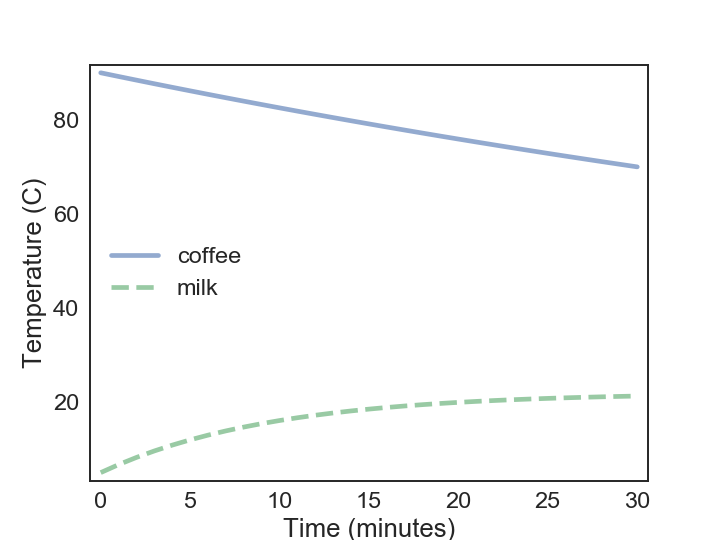

Saving figure to file chap07-fig01.pdf


In [55]:
newfig()
plot(coffee.results.temp, label='coffee')
plot(milk.results.temp, '--', label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)',
         loc='center left')

savefig('chap07-fig01.pdf')

Here's what happens when we mix them.

In [56]:
mix_last = mix(coffee, milk)
final_temp(mix_last)

63.039907187045898

And here's what we get if we add the milk immediately.

In [57]:
coffee = make_system(T_init=90, r=r_coffee, volume=300)
milk = make_system(T_init=5, r=r_milk, volume=50)

In [58]:
mix_first = mix(coffee, milk)
mix_first.t_end = 30
run_simulation(mix_first, update)
final_temp(mix_first)

61.428571428571438

The following function takes `t_add`, which is the time when the milk is added, and returns the final temperature.

In [59]:
def run_and_mix(t_add, t_total=30):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    coffee = make_system(T_init=90, t_end=t_add, 
                         r=r_coffee, volume=300)
    run_simulation(coffee, update)

    milk = make_system(T_init=5, t_end=t_add, 
                       r=r_milk, volume=50)
    run_simulation(milk, update)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    run_simulation(mixture, update)

    return final_temp(mixture)

We can try it out with a few values.

In [60]:
run_and_mix(0)

61.428571428571438

In [61]:
run_and_mix(15)

62.722755204592659

In [62]:
run_and_mix(30)

63.039907187045898

And then sweep a range of values for `t_add`

In [63]:
sweep = SweepSeries()
for t_add in linrange(0, 30, 2):
    temp = run_and_mix(t_add)
    sweep[t_add] = temp

Here's what the result looks like.

<IPython.core.display.Javascript object>


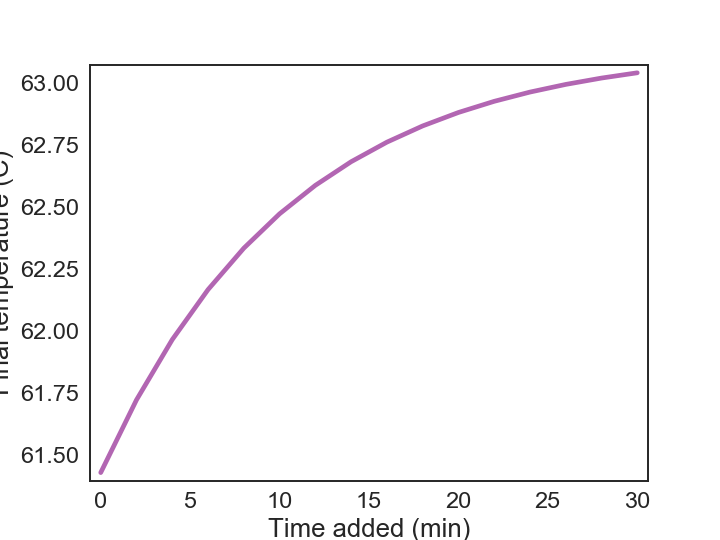

Saving figure to file chap07-fig02.pdf


In [64]:
newfig()
plot(sweep, color='purple')
decorate(xlabel='Time added (min)',
         ylabel='Final temperature (C)',
         legend=False)

savefig('chap07-fig02.pdf')

**Exercise:**  Suppose the coffee shop won't let me take milk in a separate container, but I keep a bottle of milk in the refrigerator at my office.  In that case is it better to add the milk at the coffee shop, or wait until I get to the office?

Hint: Think about the simplest way to represent the behavior of a refrigerator in this model.  The change you make to test this variation of the problem should be very small!

In [65]:
def run_and_mix_fridge(t_add, t_total=30):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    coffee = make_system(T_init=90, t_end=t_add, 
                         r=r_coffee, volume=300)
    run_simulation(coffee, update)

    milk = make_system(T_init=5, t_end=t_add, 
                       r=r_milk, volume=50)
    #removed cooling
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    run_simulation(mixture, update)

    return final_temp(mixture)

run_and_mix_fridge(30)

60.714285714285715

### Analysis

Now we can use the analytic result to compute temperature as a function of time.  The following function is similar to `run_simulation`.

In [71]:
def run_analysis(system):
    """Computes temperature using the analytic solution.
    
    Adds TimeFrame to `system` as `results`
    
    system: System object
    """
    unpack(system)
    
    T_init = init.temp    
    ts = linrange(t0, t_end, dt)
    
    temp_array = T_env + (T_init - T_env) * exp(-r * ts)
    temp_series = TimeSeries(temp_array, index=ts)
    
    system.results = TimeFrame(temp_series, columns=['temp'])

Here's how we run it.  From the analysis, we have the computed value of `r_coffee2`

In [72]:
r_coffee2 = 0.011610223142273859

In [73]:
init = State(temp=90)
coffee2 = System(init=init, T_env=22, r=r_coffee2, 
                 t0=0, t_end=30)
run_analysis(coffee2)
final_temp(coffee2)

70.0

And we can compare to the results from simulation.

In [74]:
init = State(temp=90)
coffee = System(init=init, T_env=22, r=r_coffee, 
                t0=0, t_end=30, dt=1)
run_simulation(coffee, update)
final_temp(coffee)

70.0

They are identical except for small roundoff errors.

In [75]:
coffee.results - coffee2.results

,temp
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,0.000000e+00
8,0.000000e+00
9,0.000000e+00
